In [1]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import pandas as pd
%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
class CelebA(torch.utils.data.Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.df = pd.read_csv(csv_file, delimiter=';')
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.df.iloc[idx, 0])
        image = PIL.Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        return image

In [4]:
tensor_transform = transforms.ToTensor()
dataset = CelebA(root_dir = r"C:\Users\Arek\Desktop\praca magisterska\dataset\celeb_A",
                         csv_file = r"C:\Users\Arek\Desktop\praca magisterska\dataset\celeb_A\list_attr_celeba.csv",
                         transform = tensor_transform)
train_size = 180000
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, len(dataset)-train_size])
print('train_set=',len(train_set), 'test_set=', len(test_set))

batch_size = 7
train_loader = torch.utils.data.DataLoader(dataset = train_set,
                                     batch_size = batch_size,
                                     shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_set,
                                     batch_size = batch_size,
                                     shuffle = True)

train_set= 180000 test_set= 22599


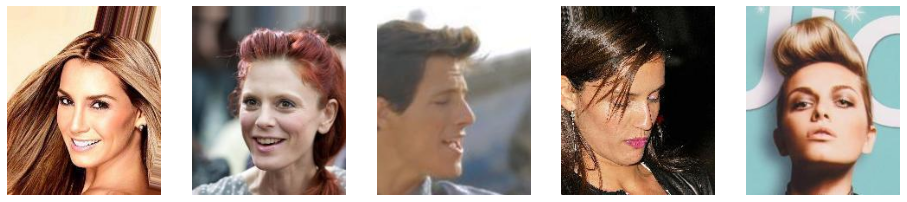

In [5]:
fig = plt.figure(figsize=(16, 12))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    sample = dataset[i]
    sample = sample.swapaxes(0, 1)
    sample = sample.swapaxes(1, 2)
    ax.axis('off')
    plt.imshow(sample)

In [6]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(3, 128, 7, 1),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.25),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(128, 128, 7, 1),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.25),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(128, 64, 5, 1),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.25),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(64, 32, 5, 1),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.25),
            torch.nn.MaxPool2d(2),
            torch.nn.Flatten(),
            torch.nn.Linear(2016,1024),
            torch.nn.ReLU()
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(1024,2016),
            torch.nn.ReLU(),
            torch.nn.Unflatten(1,(32,9,7)),
            torch.nn.Upsample(size=(19,14), mode='nearest'),
            torch.nn.ConvTranspose2d(32, 64, 5, 1),
            torch.nn.ReLU(),
            torch.nn.Upsample(size=(46,36), mode='nearest'),
            torch.nn.ConvTranspose2d(64, 128, 5, 1),
            torch.nn.ReLU(),
            torch.nn.Upsample(size=(100,80), mode='nearest'),
            torch.nn.ConvTranspose2d(128, 128, 7, 1),
            torch.nn.ReLU(),
            torch.nn.Upsample(size=(212,172), mode='nearest'),
            torch.nn.ConvTranspose2d(128, 3, 7, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [7]:
model = AE().to(device)
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 0.001,
                             weight_decay = 1e-8)

In [12]:
from torchsummary import summary
summary(model, (3, 218, 178))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 212, 172]          18,944
              ReLU-2        [-1, 128, 212, 172]               0
           Dropout-3        [-1, 128, 212, 172]               0
         MaxPool2d-4         [-1, 128, 106, 86]               0
            Conv2d-5         [-1, 128, 100, 80]         802,944
              ReLU-6         [-1, 128, 100, 80]               0
           Dropout-7         [-1, 128, 100, 80]               0
         MaxPool2d-8          [-1, 128, 50, 40]               0
            Conv2d-9           [-1, 64, 46, 36]         204,864
             ReLU-10           [-1, 64, 46, 36]               0
          Dropout-11           [-1, 64, 46, 36]               0
        MaxPool2d-12           [-1, 64, 23, 18]               0
           Conv2d-13           [-1, 32, 19, 14]          51,232
             ReLU-14           [-1, 32,

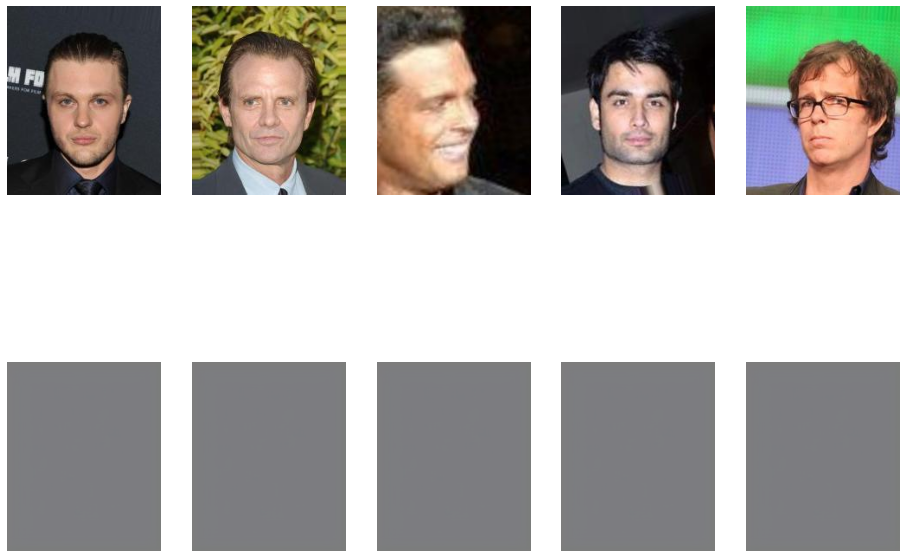

 Epoch 1, batch [25715/25715]	 loss: 0.002669	 test loss: 0.049274


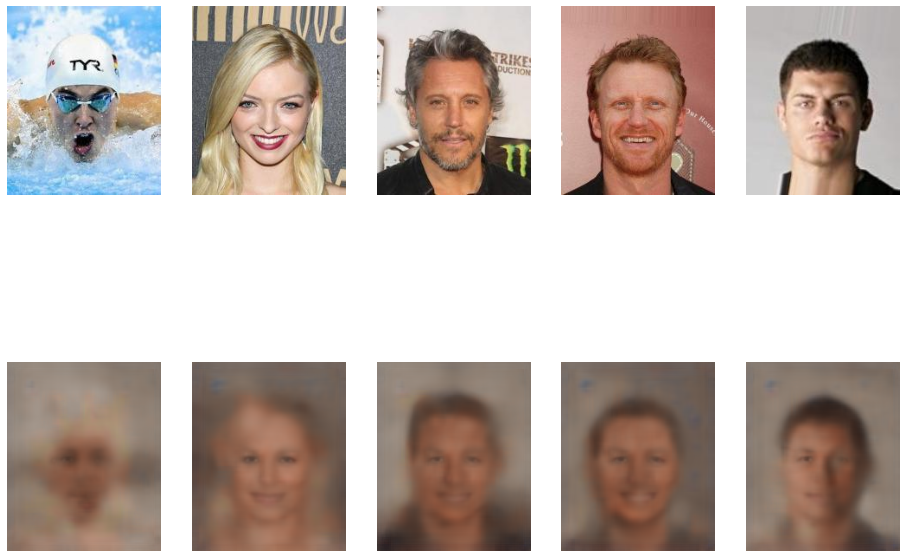

 Epoch 2, batch [23324/25715]	 loss: 0.002276

In [ ]:
def draw():
    with torch.no_grad():
        fig = plt.figure(figsize=(16, 12))
        model.eval()
        for i, image in enumerate(test_loader):
            image = image.to(device)
            pred = model(image)
            image = image.cpu()
            pred = pred.cpu()
            sample = image[0].numpy()
            sample = sample.swapaxes(0, 1)
            sample = sample.swapaxes(1, 2)
            ax = plt.subplot(2, 5, i + 1)
            ax.axis('off')
            plt.imshow(sample)
            sample = pred[0].numpy()
            sample = sample.swapaxes(0, 1)
            sample = sample.swapaxes(1, 2)
            ax = plt.subplot(2, 5, 5 + i + 1)
            ax.axis('off')
            plt.imshow(sample)
            if i >= 4:
                plt.show(block = False)
                plt.close()
                break


train_size, test_size = len(train_loader.dataset), len(test_loader.dataset)
for epoch in range(10):
    draw()
    model.train()
    train_loss = 0
    for i, image in enumerate(train_loader):
        image = image.to(device)
        pred = model(image)
        loss = loss_function(pred, image)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        loss= train_loss / (i+1)
        print(f"\r Epoch {epoch+1}, batch [{i+1:>5d}/{int(np.ceil(train_size/batch_size)):>5d}]\t loss: {loss:>7f}", end="")

    test_loss = 0
    with torch.no_grad():
        model.eval()
        for image in test_loader:
            image = image.to(device)
            
            pred = model(image)
            test_loss += loss_function(pred, image).item()
    
    test_loss = test_loss / len(test_loader)
    print(f"\t test loss: {test_loss:>7f}")

In [12]:
torch.save(model.state_dict(), 'model')

In [14]:
model.load_state_dict(torch.load('model'))
model.eval()

AE(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(7, 7), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
    (7): ReLU()
    (8): Dropout(p=0.25, inplace=False)
    (9): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
    (10): ReLU()
    (11): Conv2d(128, 256, kernel_size=(7, 7), stride=(2, 2))
    (12): ReLU()
    (13): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
    (14): ReLU()
    (15): Dropout(p=0.25, inplace=False)
    (16): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
    (17): ReLU()
    (18): Conv2d(128, 256, kernel_size=(7, 7), stride=(2, 2))
    (19): ReLU()
    (20): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
    (21): ReLU()
    (22): Dropout(p=0.25, inplace=False)
    (23): Conv2d(64, 64, kernel_size=(5, 5), stride=(2, 2))
    (24): ReLU()
